In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from variational_forms import _VariationalForm
from feature_maps import MediumFeatureMap
from pegasos_experiment import generate_qsvm_data, run_advanced_experiment
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from quantum_neural_networks import QuantumNeuralNetwork
from qiskit import BasicAer

In [2]:
blue = '#1f77b4'
orange = '#ff7f0e'
green = '#2ca02c'
red = '#d62728'
violet = '#9467bd'
grey = '#7f7f7f'
cyan = '#17becf'

colormap = {
    1.0 : blue,
    2.0 : blue,
    4.0 : green,
    8.0 : red,
    64. : violet,
    256. : grey,
    512. : cyan,
    1024. : orange,

}

# other constants
lower_percentile = 0.159
upper_percentile = 0.841

plt.rcParams.update({'font.size': 24,
                     'xtick.labelsize': 20,
                     'ytick.labelsize': 20,
                     'axes.titlesize': 28,
                     'axes.labelsize': 28,
                     'mathtext.fontset': 'stix',
                     'font.family': 'STIXGeneral'})

In [3]:
margin = +0.1
positive = 'positive' if margin > 0 else 'negative'
filename = f'data/advanced_margin_{margin}_data.csv'
# data size
M = 100
# iterations
N = 1000
# number of repeats per experiment
n = 50


In [4]:
shots = [1,4,8,64,256,512,1024]
Cs = [10.,1000.]

for C in Cs:
    run_advanced_experiment(margin,C,N,shots,M,0,n)
        

Approximating Kernels


0it [00:00, ?it/s]/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:303: ComplexWarning: Casting complex values to real discards the imaginary part
  K_shots[i] = R_shots_kernel.evaluate(x_vec=X)
7it [01:57, 16.82s/it]
  0%|          | 0/50 [00:00<?, ?it/s]/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encou

Approximating Kernels


0it [00:00, ?it/s]/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:303: ComplexWarning: Casting complex values to real discards the imaginary part
  K_shots[i] = R_shots_kernel.evaluate(x_vec=X)
7it [01:52, 16.07s/it]
  0%|          | 0/50 [00:00<?, ?it/s]/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1. - np.sum(np.abs(y1 - y2),axis=-1)/(2.*len(y1)))
/Users/gge/Documents/complexity_of_qsvm/pegasos_qsvm/pegasos_experiment.py:120: RuntimeWarning: invalid value encou

In [5]:
 # Feature map for the experiment
feature_map = MediumFeatureMap(2,4)


# Creating artificial data
(X,y), (Xt,yt) = generate_qsvm_data(feature_map,margin,M,100)

np.random.seed(41)

# Change to qasm-simulator if noise is modelled via shots
adhoc_backend = QuantumInstance(BasicAer.get_backend('statevector_simulator'))

adhoc_kernel = QuantumKernel(feature_map=feature_map.get_reduced_params_circuit(), quantum_instance=adhoc_backend)

# Kernel evaluation
K = adhoc_kernel.evaluate(x_vec=X)


In [29]:
# load data
data = pd.read_csv(filename)

epsilons1 = []
epsilons2 = []
stops = []


for j, r in data.iterrows():
    file = f"data/dumps/{int(r['seed'])}_R_{int(r['R'])}_C_{r['C']}_M_{int(r['M'])}_margin_{margin}"
    history = pickle.load(open(file,'rb')) 
    hinges = history['hinge_loss'] 
    eps1 = history['epsilons']
    eps2 = history['epsilons2']


    #eps = np.array([np.max(np.abs(np.sum(y*(a[i] - a_state[-1])*K,axis=1))) for i in range(len(a_state))])

    diff = np.abs(hinges[1:] - hinges[:-1])
    stop = np.where(diff < 1e-4)[0][0]
    epsilons1.append(eps1)
    epsilons2.append(eps2)
    stops.append(stop)

stops = np.array(stops)
epsilons1 = np.array(epsilons1)
epsilons2 = np.array(epsilons2)

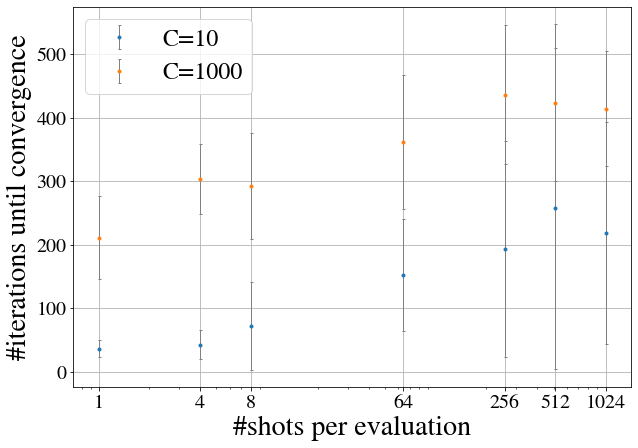

In [30]:
def plot_conv(C):
    stops_R = np.array([stops[(data['R'] == R) & (data['C'] == C)] for R in shots])
    stop_means = np.mean(stops_R,axis=1)
    stop_std = np.std(stops_R,axis=1)
    plt.errorbar(shots,stop_means,yerr=stop_std,label=f'C={int(C)}',marker='.',ecolor='grey',elinewidth=1.,ls='',capsize=1 + M/200)

plt.figure(figsize=(10,7))
for C in Cs:
    plot_conv(C)
plt.xscale('log')
plt.xticks(shots,shots)
plt.xlabel('#shots per evaluation')
plt.ylabel('#iterations until convergence')
plt.legend()
plt.grid()
#plt.savefig(f'plots/convergence_{positive}_margin.png',dpi=200)


[-3.27778699 -1.29376177]
[-4.79264002 10.1911663 ]


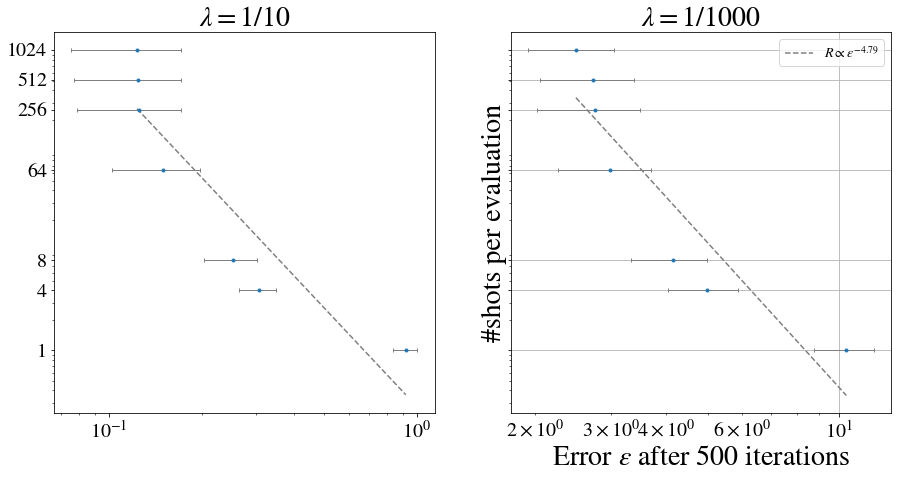

In [9]:
def plot_epsilon(C,stop_at,ax):
    filter = data['C'] == C
    epsC = np.array([epsilons2[:,stop_at][filter & (data['R'] == R)] for R in shots])
    eps_means = np.mean(epsC,axis=1)
    eps_std = np.std(epsC,axis=1)
    ax.errorbar(eps_means,shots,xerr=eps_std,marker='.',ecolor='grey',elinewidth=1.,ls='',capsize=2)
    p = np.polyfit(np.log(eps_means),np.log(shots),1)
    print(p)
    efine = np.linspace(np.min(eps_means),np.max(eps_means))
    ax.plot(efine,np.exp(p[1])*efine**p[0],'--',color='grey',label=r'$R\propto\varepsilon^{{%.2f}}$'%p[0])
    ax.set_title(r'$\lambda = 1/{{%s}}$'%int(C))
    ax.set_xscale('log')
    ax.set_yscale('log')

fig, axs = plt.subplots(1,2,sharey=True,figsize=(15,7))
for i, C in enumerate(Cs):
    plot_epsilon(C,500,axs[i])

plt.yticks(shots,shots)
plt.ylabel('#shots per evaluation')
plt.xlabel(r'Error $\varepsilon$ after 500 iterations')
plt.legend(fontsize=14)
plt.grid()

#plt.savefig(f'plots/exponent_{positive}_margin_500.png',dpi=200)


[-1.85195765 -0.66598419]
[-3.35452778  5.78803874]


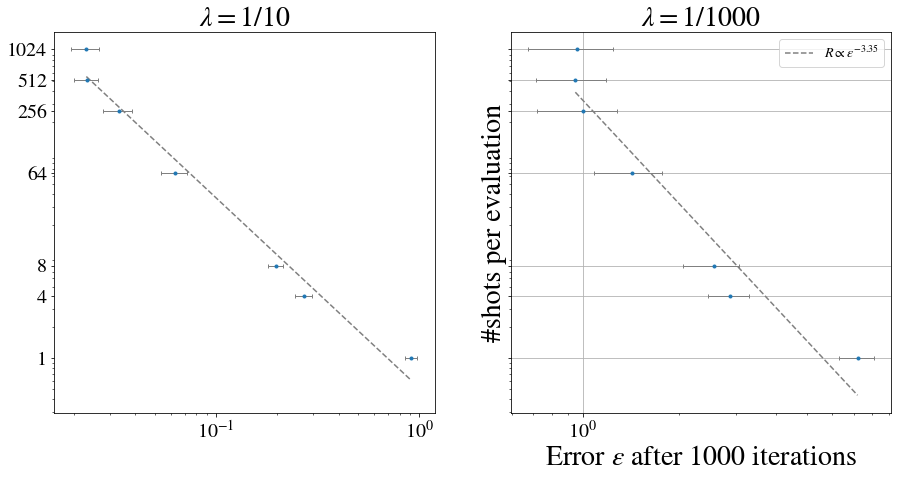

In [10]:
fig, axs = plt.subplots(1,2,sharey=True,figsize=(15,7))
for i, C in enumerate(Cs):
    plot_epsilon(C,-1,axs[i])

plt.yticks(shots,shots)
plt.ylabel('#shots per evaluation')
plt.xlabel(r'Error $\varepsilon$ after 1000 iterations')
plt.legend(fontsize=14)
plt.grid()

In [28]:
def plot_epsilon_convergence(C):
    filter = data['C'] == C
    epsilons_conv = np.array([epsilons2[i,stops[i]] for i in range(len(epsilons2))])
    epsC = np.array([epsilons_conv[filter & (data['R'] == R)] for R in shots])
    eps_means = np.mean(epsC,axis=1)
    eps_std = np.std(epsC,axis=1)
    plt.errorbar(eps_means,shots,xerr=eps_std,label=f'C={int(C)}',marker='.',ecolor='grey',elinewidth=1.,ls='',capsize=1 + C/200)
    p = np.polyfit(np.log(eps_means),np.log(shots),1)
    print(p)
    if M == 100:
        efine = np.linspace(np.min(eps_means),np.max(eps_means))
        plt.plot(efine,np.exp(p[1])*efine**p[0],'--',color='grey',label=r'$R\propto\varepsilon^{{%.2f}}$'%p[0])


plt.figure(figsize=(10,7))
for C in Cs:
    plot_epsilon_convergence(C)
plt.xscale('log')
plt.yscale('log')
plt.yticks(shots,shots)
plt.ylabel('#shots per evaluation')
plt.xlabel(r'Error $\varepsilon$ after convergence')
plt.legend(fontsize=14)
plt.grid()
plt.savefig(f'plots/exponent_{positive}_margin_convergence.png',dpi=200)


TypeError: list indices must be integers or slices, not tuple

<Figure size 720x504 with 0 Axes>

4
0.09020425729199721
[-2.71458898  5.60762429]
2.666225761269347
[-2.86426566 14.92446638]


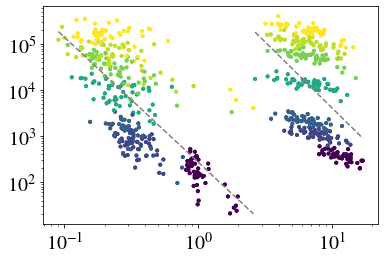

In [20]:
def plot_epsilon_convergence(C):
    filter = data['C'] == C
    epsilons_conv = np.array([epsilons2[i,stops[i]] for i in range(len(epsilons2))])[filter]
    total_shots = (stops*data['R'])[filter]
    colours = np.log(data['R'])[filter]
    plt.scatter(epsilons_conv,total_shots,marker='.',cmap='viridis',c=colours)
    print(min(epsilons_conv))
    p = np.polyfit(np.log(epsilons_conv),np.log(total_shots),1)
    print(p)
    efine = np.linspace(np.min(epsilons_conv),np.max(epsilons_conv))
    plt.plot(efine,np.exp(p[1])*efine**p[0],'--',color='grey',label=r'$R\propto\varepsilon^{{%.2f}}$'%p[0])

print(min(stops))
plt.yscale('log')
plt.xscale('log')
for C in Cs:
    plot_epsilon_convergence(C)
